Importing Libraries

In [343]:
import pyedflib as edf
import numpy as np
import glob
import random
import antropy as ent
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, find_peaks_cwt, find_peaks, periodogram
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, MaxPooling1D, BatchNormalization
from tensorflow.keras.utils import to_categorical

Loading data

In [344]:
WINDOW_STEP = 256

files = glob.glob('../data/*.edf')

seizure_period_foreach_file = [
    (2996, 3036),
    (1467, 1494),
    (1732, 1772),
    (1015, 1066),
    (1720, 1810),
    (327, 420),
    (1862, 1963),
    (130, 212),
    (2972, 3053),
    (362, 414),
    (731, 796),
    (432, 501),
    (2162, 2214),
    (7804, 7853),
    (1679, 1781),
    (3782, 3898),
    (417, 532),
    (1086, 1196),
    (2317, 2413),
    (2451, 2571),
    (2348, 2465),
    (327, 347),
    (6211, 6231),
    (12500, 12516),
    (10833, 10845),
    (506, 519),
    (7799, 7811),
    (9387, 9403),
    (4920, 5006),
    (3285, 3381),
    (13688, 13831),
    (2670, 2841),
    (2856, 3046),
    (2988, 3122),
    (2417, 2577),
    (2083, 2347),
    (12231, 12295),
    (2951, 3030),
    (9196, 9267),
    (5299, 5361),
    (6313, 6348),
    (6888, 6958),
    (2382, 2447),
    (3021, 3079),
    (3801, 3877),
    (4618, 4707),
    (1383, 1437),
]

seizure_period_concat_with_file = zip(files, seizure_period_foreach_file)

seizure_period_concat_with_file = [(file_name, start, end) 
                                    for file_name, (start, end) in seizure_period_concat_with_file]

signals = []

for file in files:
    with edf.EdfReader(file) as edf_reader:
        signal_labels = edf_reader.getSignalLabels()
        
        fz_cz_index = signal_labels.index('FZ-CZ')
        cz_pz_index = signal_labels.index('CZ-PZ')
        
        buffers = np.zeros((2, edf_reader.getNSamples()[0]))
        
        buffers[0] = edf_reader.readSignal(fz_cz_index)
        buffers[1] = edf_reader.readSignal(cz_pz_index)
        
        array_buffer = np.array(buffers)
        signals.append(array_buffer)

len(signals)

44

Plot some of signals to identify shape of each signals

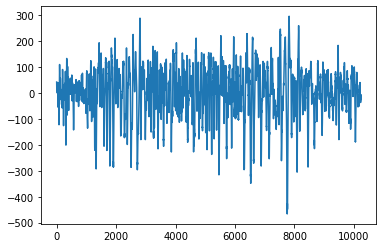

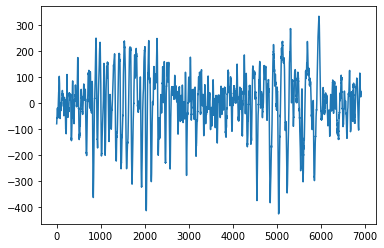

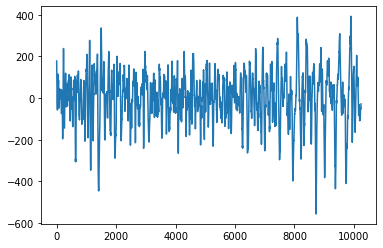

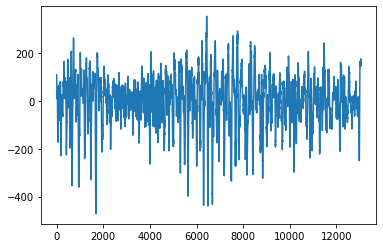

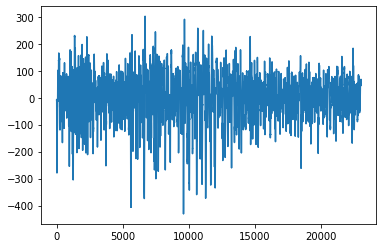

In [345]:
sample_signals = seizure_period_concat_with_file[0:5]

for i, signal in enumerate(sample_signals):
    filename, start, end = signal
    plt.plot(signals[i][0][start * WINDOW_STEP:end * WINDOW_STEP])
    plt.show()

Getting seizure part of signal and labeling it with 5 * 256 window.
We use 5 seconds window to label seizure part of signal and getting more data

In [346]:
WINDOW_SIZE = 5 * WINDOW_STEP

seizure_signals = np.zeros((0, 2, WINDOW_SIZE))
seizure_y_labels = []

for index in range(len(signals)):
    try:
        start_time = seizure_period_concat_with_file[index][1] * WINDOW_STEP
        end_time = seizure_period_concat_with_file[index][2] * WINDOW_STEP
        for j in range(start_time, end_time, WINDOW_SIZE):
            seizure_signals = np.append(seizure_signals, 
                                        np.array([signals[index][:, j:j + WINDOW_SIZE]]), axis=0)
            seizure_y_labels.append(1)
    except:
        continue

seizure_signals.shape

(634, 2, 1280)

Plot some of seizure signals

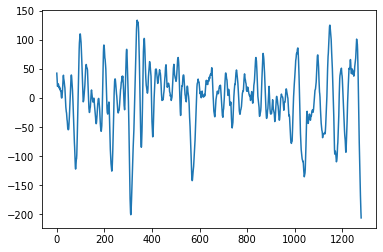

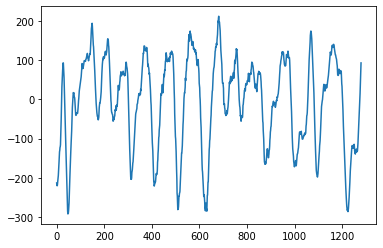

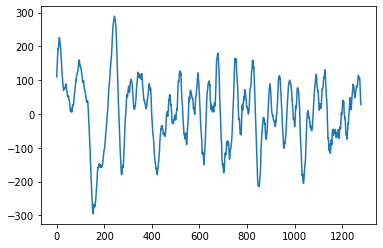

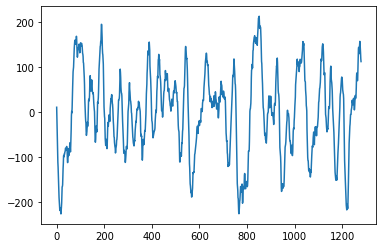

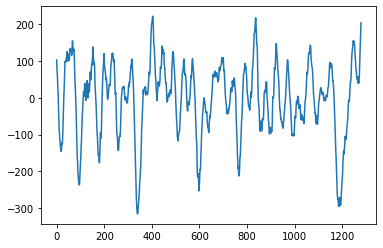

In [347]:
sample_signals = seizure_signals[0:5]

for i in range(len(sample_signals)):
    plt.plot(sample_signals[i][0])
    plt.show()

Deleting first 5% & last 5% signals (noise)

In [348]:
def remove_noise(signals):
    for index in range(len(signals)):
        low_range = int(0.05 * len(signals[i][0]))
        high_range = int(0.95*len(signals[i][0]))
        signals[i] = signals[i][:,low_range:high_range]

    return signals

signals_without_noise = remove_noise(signals)

len(signals_without_noise)

44

Removing the seizure part of each signal

In [349]:
for i in range(len(signals_without_noise)):
    try:
        start_time = seizure_period_concat_with_file[i][1] * WINDOW_STEP
        end_time = seizure_period_concat_with_file[i][2] * WINDOW_STEP
        signals_without_noise[i] = np.delete(signals_without_noise[i], np.s_[start_time:end_time], axis=1)
    except:
        continue

len(signals_without_noise)

44

Getting non-seizure part of each signal & labeling each 5 * 256 random window

In [350]:
WINDOW_SIZE = 5 * WINDOW_STEP

non_seizure_signals = np.zeros((0, 2, WINDOW_SIZE))
non_seizure_y_labels = []

for index in range(len(signals_without_noise)):
    try:
        for j in range(WINDOW_STEP):
            random_index = random.randint(0, len(signals_without_noise[i][0]) - WINDOW_SIZE)
            non_seizure_signals = np.append(non_seizure_signals, 
                                        np.array([signals_without_noise[index][:, random_index:random_index + WINDOW_SIZE]]), axis=0)
            non_seizure_y_labels.append(0)
    except:
        continue

non_seizure_signals.shape

(4630, 2, 1280)

Plot non-seizure signals

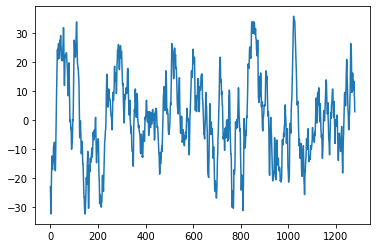

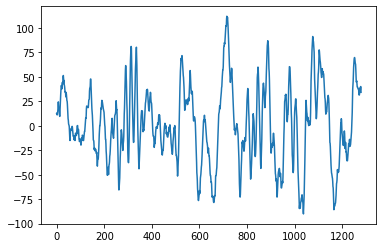

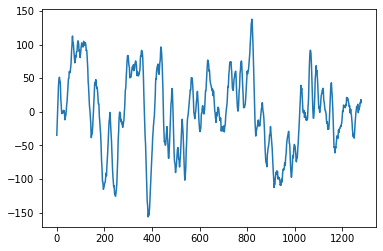

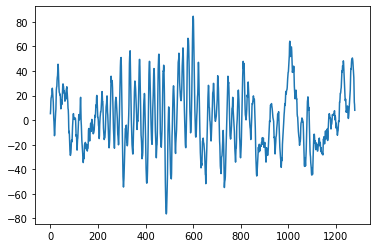

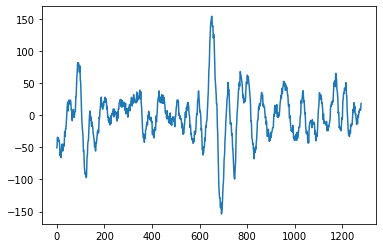

In [351]:
sample_signals = non_seizure_signals[0:5]

for i in range(len(sample_signals)):
    plt.plot(sample_signals[i][0])
    plt.show()

Preparing final data

In [352]:
final_signals = np.zeros((0, 2, WINDOW_SIZE))
final_y_labels = []

In [353]:
final_signals = np.append(seizure_signals, non_seizure_signals, axis=0)
final_y_labels = np.append(seizure_y_labels, non_seizure_y_labels, axis=0)

print(final_signals.shape, final_y_labels.shape)

(5264, 2, 1280) (5264,)


Plot some of each final signals

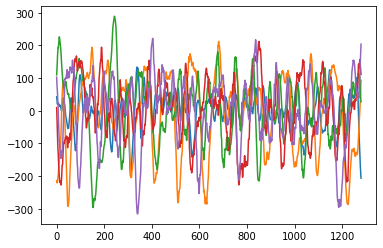

In [354]:
for i in range(len(final_signals[0:5])):
    plt.plot(final_signals[i][0])

plt.show()

Feature Extraction

* variance
* std
* mean
* fft
* fft2
* power
* power specular
* complexity
* zero crossing rate

In [355]:
def var(data):
    return np.var(data, axis=2)

def std(data):
    return np.std(data, axis=2)

def mean(data):
    return np.mean(data, axis=2)

def fft(data):
    return np.fft.fft(data, axis=2)

def fft_var(data):
    fft = np.fft.fft(data, axis=2)
    return np.var(fft, axis=2)

def fft_std(data):
    fft = np.fft.fft(data, axis=2)
    return np.std(fft, axis=2)

def fft_mean(data):
    fft = np.fft.fft(data, axis=2)
    return np.mean(fft, axis=2)

def fft2_var(data):
    fft2 = np.fft.fft2(data)
    fft2_abs = np.abs(fft2)
    return np.var(fft2_abs, axis=2)

def fft2_std(data):
    fft2 = np.fft.fft2(data)
    fft2_abs = np.abs(fft2)
    return np.std(fft2_abs, axis=2)

def fft2_mean(data):
    fft2 = np.fft.fft2(data)
    fft2_abs = np.abs(fft2)
    return np.mean(fft2_abs, axis=2)

def power(data):
    return np.sum(np.square(data), axis=2)

# calculate power spectral density for each signal
def power_specular_var(data):
    power_specular = np.array([periodogram(data[index, :])[1] for index in range(data.shape[0])])
    return np.var(power_specular, axis=2)

def power_specular_std(data):
    power_specular = np.array([periodogram(data[index, :])[1] for index in range(data.shape[0])])
    return np.var(power_specular, axis=2)

def power_specular_mean(data):
    power_specular = np.array([periodogram(data[index, :])[1] for index in range(data.shape[0])])
    return np.var(power_specular, axis=2)

def complexity(data):
    fft = np.fft.fft(data)
    return np.sum(np.square(np.abs(np.diff(fft, axis=2))), axis=2)

def zero_crossing_rate(data):
    return np.sum(np.abs(np.diff(np.sign(data), axis=2)), axis=2)

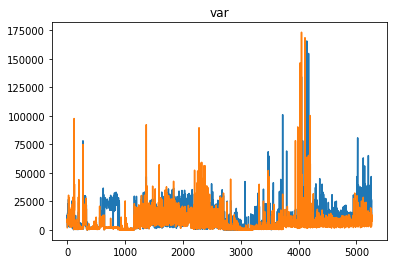

In [356]:
var = var(final_signals)

plt.title('var')
plt.plot(var)
plt.show()

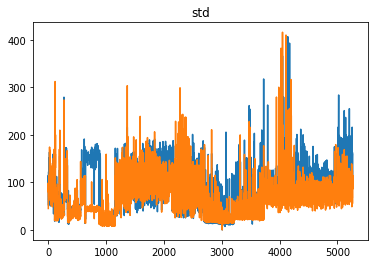

In [357]:
std = std(final_signals)

plt.title('std')
plt.plot(std)
plt.show()

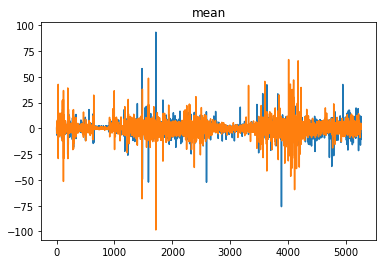

In [358]:
mean = mean(final_signals)

plt.title('mean')
plt.plot(mean)
plt.show()

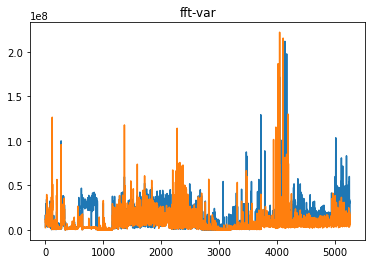

In [359]:
fft_var = fft_var(final_signals)

plt.title('fft-var')
plt.plot(fft_var)
plt.show()

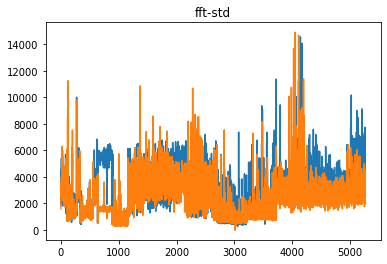

In [360]:
fft_std = fft_std(final_signals)

plt.title('fft-std')
plt.plot(fft_std)
plt.show()

c:\Users\SQ-PC\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


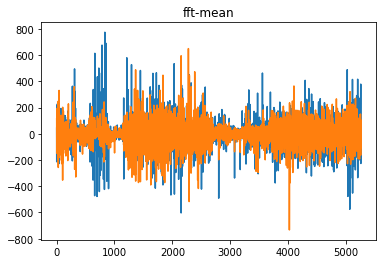

In [361]:
fft_mean = fft_mean(final_signals)

plt.title('fft-mean')
plt.plot(fft_mean)
plt.show()

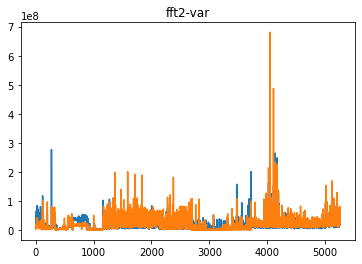

In [362]:
fft2_var = fft2_var(final_signals)

plt.title('fft2-var')
plt.plot(fft2_var)
plt.show()

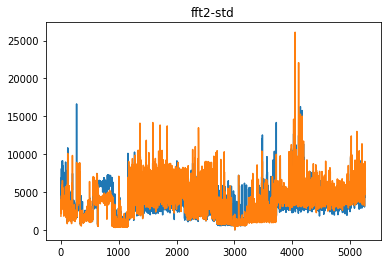

In [363]:
fft2_std = fft2_std(final_signals)

plt.title('fft2-std')
plt.plot(fft2_std)
plt.show()

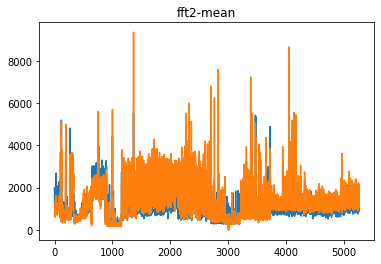

In [364]:
fft2_mean = fft2_mean(final_signals)

plt.title('fft2-mean')
plt.plot(fft2_mean)
plt.show()

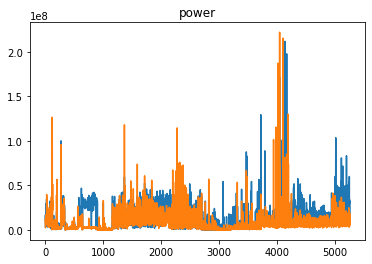

In [365]:
power = power(final_signals)

plt.title('power')
plt.plot(power)
plt.show()

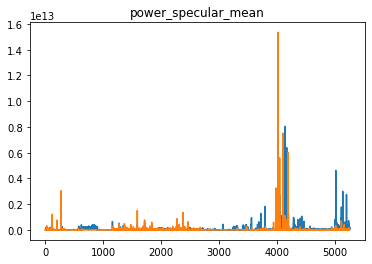

In [366]:
power_specular_mean = power_specular_mean(final_signals)

plt.title('power_specular_mean')
plt.plot(power_specular_mean)
plt.show()

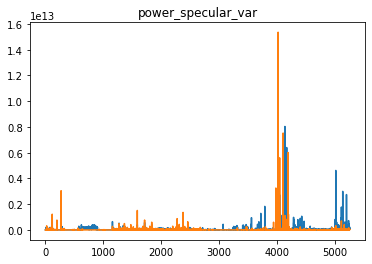

In [367]:
power_specular_var = power_specular_var(final_signals)

plt.title('power_specular_var')
plt.plot(power_specular_var)
plt.show()

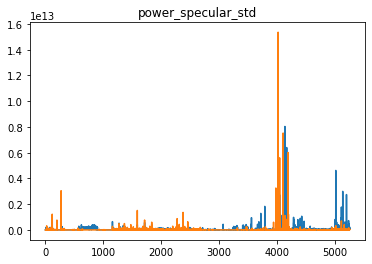

In [368]:
power_specular_std = power_specular_std(final_signals)

plt.title('power_specular_std')
plt.plot(power_specular_std)
plt.show()

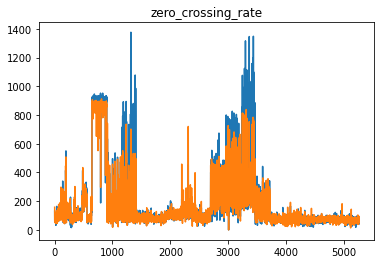

In [369]:
zero_crossing_rate = zero_crossing_rate(final_signals)

plt.title('zero_crossing_rate')
plt.plot(zero_crossing_rate)
plt.show()

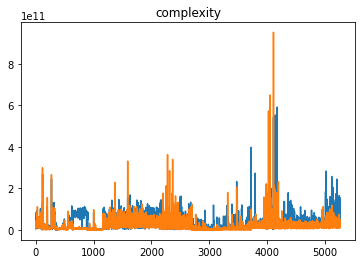

In [370]:
complexity = complexity(final_signals)

plt.title('complexity')
plt.plot(complexity)
plt.show()

Concatenating the features

In [371]:
features = np.concatenate((var
                          ,std
                          ,mean
                          ,fft_var
                          ,fft_std
                          ,fft2_var
                          ,fft2_std
                          ,fft2_mean
                          ,power
                          ,power_specular_var
                          ,power_specular_std
                          ,power_specular_mean
                          ,zero_crossing_rate
                          ,complexity), axis=1)

features.shape

(5264, 28)

0.8651471984805318
[[911   0]
 [142   0]]


c:\Users\SQ-PC\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


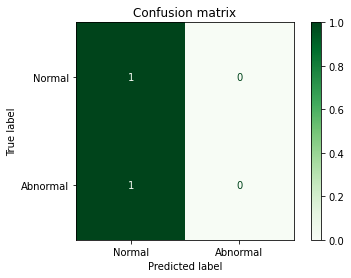

In [372]:
x_train, x_test, y_train, y_test = train_test_split(features, final_y_labels, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)

clf.fit(x_train, y_train)

y_prediction = clf.predict(x_test)

print(accuracy_score(y_test, y_prediction))

print(confusion_matrix(y_test, y_prediction))

display = plot_confusion_matrix(clf, x_test, y_test, display_labels=['Normal', 'Abnormal'], cmap=plt.cm.Greens, normalize='true')
display.ax_.set_title('Confusion matrix')
plt.show()

In [373]:
x_train, x_test, y_train, y_test = train_test_split(final_signals, final_y_labels, test_size=0.2, random_state=42)

y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

CNN

A neural network with 3 convolutional layers, 3 max pooling and 2 fully connected layers.

* Kernel Size = Size of window
* Filter = Number of filter
* Dense Layer = Number of neurons
* Dropout Layer = Number of neurons in dropping level

In [374]:
KERNEL_SIZE = 5
FILTER_SIZE = 256
POOL_SIZE = 2
DROPOUT = 0.3
DENSE_1 = 256
DENSE_2 = 2

sequential = Sequential()

sequential.add(Conv1D(filters=FILTER_SIZE
                     ,kernel_size=KERNEL_SIZE
                     ,activation='relu'
                     ,input_shape=(WINDOW_SIZE, 2)))
sequential.add(MaxPooling1D(pool_size=POOL_SIZE))
sequential.add(Dropout(DROPOUT))

sequential.add(Conv1D(filters=FILTER_SIZE / 2
                     ,kernel_size=KERNEL_SIZE
                     ,activation='relu'))
sequential.add(MaxPooling1D(pool_size=POOL_SIZE))
sequential.add(Dropout(DROPOUT))

sequential.add(Conv1D(filters=FILTER_SIZE / 4
                     ,kernel_size=KERNEL_SIZE
                     ,activation='relu'))
sequential.add(MaxPooling1D(pool_size=POOL_SIZE))
sequential.add(Dropout(DROPOUT))

sequential.add(Flatten())

#add our features to the last fully connected layer
sequential.add(Dense(DENSE_1, activation='relu'))
sequential.add(Dense(DENSE_2, activation='softmax'))

sequential.summary()

sequential.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_18 (Conv1D)          (None, 1276, 256)         2816      
                                                                 
 max_pooling1d_15 (MaxPoolin  (None, 638, 256)         0         
 g1D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 638, 256)          0         
                                                                 
 conv1d_19 (Conv1D)          (None, 634, 128)          163968    
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 317, 128)         0         
 g1D)                                                            
                                                                 
 dropout_13 (Dropout)        (None, 317, 128)         

In [375]:
x_train = x_train.reshape(x_train.shape[0], WINDOW_SIZE, 2).astype('float32')
x_test = x_test.reshape(x_test.shape[0], WINDOW_SIZE, 2).astype('float32')

In [376]:
sequential.fit(x_train, y_train_categorical, epochs=10, shuffle=True, verbose=2)

Epoch 1/10
132/132 - 210s - loss: 1.3223 - accuracy: 0.8782 - 210s/epoch - 2s/step
Epoch 2/10
132/132 - 180s - loss: 0.4029 - accuracy: 0.8832 - 180s/epoch - 1s/step
Epoch 3/10
132/132 - 184s - loss: 0.3935 - accuracy: 0.8832 - 184s/epoch - 1s/step
Epoch 4/10
132/132 - 172s - loss: 0.4022 - accuracy: 0.8832 - 172s/epoch - 1s/step
Epoch 5/10
132/132 - 172s - loss: 0.3654 - accuracy: 0.8836 - 172s/epoch - 1s/step
Epoch 6/10
132/132 - 165s - loss: 0.3639 - accuracy: 0.8832 - 165s/epoch - 1s/step
Epoch 7/10
132/132 - 158s - loss: 0.3545 - accuracy: 0.8832 - 158s/epoch - 1s/step
Epoch 8/10
132/132 - 149s - loss: 0.3547 - accuracy: 0.8832 - 149s/epoch - 1s/step
Epoch 9/10
132/132 - 146s - loss: 0.3489 - accuracy: 0.8834 - 146s/epoch - 1s/step
Epoch 10/10
132/132 - 139s - loss: 0.3476 - accuracy: 0.8834 - 139s/epoch - 1s/step


In [377]:
model_loss, model_accuracy = sequential.evaluate(x_test, y_test_categorical, verbose=2)
print(f"CNN - Loss: {model_loss}, Accuracy: {model_accuracy}")

33/33 - 13s - loss: 0.3783 - accuracy: 0.8651 - 13s/epoch - 407ms/step
CNN - Loss: 0.3783296048641205, Accuracy: 0.8651471734046936


In [378]:
y_prediction = sequential.predict(x_test)
y_prediction = np.argmax(y_prediction, axis=1)
y_test = np.argmax(y_test_categorical, axis=1)
print(classification_report(y_test, y_prediction))

33/33 [==============================] - 8s 228ms/step
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       911
           1       0.00      0.00      0.00       142

    accuracy                           0.87      1053
   macro avg       0.43      0.50      0.46      1053
weighted avg       0.75      0.87      0.80      1053



c:\Users\SQ-PC\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\SQ-PC\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\SQ-PC\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [379]:
matrix = confusion_matrix(y_test, y_prediction)

true_positive = matrix[0][0]
false_positive = matrix[0][1]
true_negative = matrix[1][0]
false_negative = matrix[1][1]

false_alarm_rate = false_positive / (true_positive + false_positive)
missing_rate = true_negative / (true_negative + false_negative)

print(f'false alarm rate: {false_alarm_rate}, missing rate: {missing_rate}')

false alarm rate: 0.0, missing rate: 1.0


In [380]:
fpr, tpr, thresholds = roc_curve(y_test, y_prediction)
roc_auc = auc(fpr, tpr)

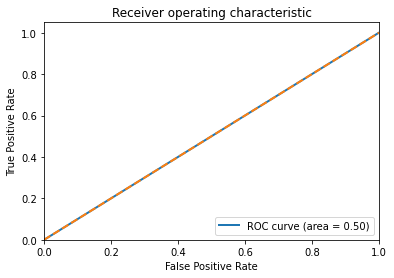

In [381]:
plt.plot(fpr, tpr, lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [382]:
LEARNING_RATE = 0.01

sequential_b = Sequential()
sequential_b.add(Conv1D(filters=FILTER_SIZE
                     ,kernel_size=KERNEL_SIZE
                     ,activation='relu'
                     ,input_shape=(WINDOW_SIZE, 2)))
sequential_b.add(MaxPooling1D(pool_size=POOL_SIZE))
sequential_b.add(BatchNormalization())
sequential_b.add(Conv1D(filters=FILTER_SIZE / 2
                ,kernel_size=KERNEL_SIZE
                ,activation='relu'
                ,input_shape=(WINDOW_SIZE, 2)))

sequential_b.add(Flatten())

sequential_b.add(Dense(features.shape[1], activation='relu'))
sequential_b.add(Dense(2, activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

sequential_b.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
sequential_b.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_21 (Conv1D)          (None, 1276, 256)         2816      
                                                                 
 max_pooling1d_18 (MaxPoolin  (None, 638, 256)         0         
 g1D)                                                            
                                                                 
 batch_normalization_3 (Batc  (None, 638, 256)         1024      
 hNormalization)                                                 
                                                                 
 conv1d_22 (Conv1D)          (None, 634, 128)          163968    
                                                                 
 flatten_8 (Flatten)         (None, 81152)             0         
                                                                 
 dense_16 (Dense)            (None, 28)               

In [383]:
sequential_b.fit(x_train, y_train_categorical, epochs=10, shuffle=True, verbose=2)

Epoch 1/10
132/132 - 68s - loss: 0.7608 - accuracy: 0.8642 - 68s/epoch - 514ms/step
Epoch 2/10
132/132 - 67s - loss: 0.3352 - accuracy: 0.8832 - 67s/epoch - 510ms/step
Epoch 3/10
132/132 - 67s - loss: 0.3253 - accuracy: 0.8832 - 67s/epoch - 507ms/step
Epoch 4/10
132/132 - 67s - loss: 0.3166 - accuracy: 0.8832 - 67s/epoch - 508ms/step
Epoch 5/10
132/132 - 67s - loss: 0.2953 - accuracy: 0.8832 - 67s/epoch - 509ms/step
Epoch 6/10
132/132 - 67s - loss: 0.2834 - accuracy: 0.8832 - 67s/epoch - 507ms/step
Epoch 7/10
132/132 - 67s - loss: 0.2616 - accuracy: 0.8832 - 67s/epoch - 509ms/step
Epoch 8/10
132/132 - 67s - loss: 0.2424 - accuracy: 0.8832 - 67s/epoch - 508ms/step
Epoch 9/10
132/132 - 67s - loss: 0.2450 - accuracy: 0.8919 - 67s/epoch - 509ms/step
Epoch 10/10
132/132 - 68s - loss: 0.2242 - accuracy: 0.9083 - 68s/epoch - 512ms/step


In [384]:
model_loss, model_accuracy = sequential_b.evaluate(x_test, y_test_categorical, verbose=2)
print(f"CNN - Loss: {model_loss}, Accuracy: {model_accuracy}")

33/33 - 4s - loss: 0.5200 - accuracy: 0.8405 - 4s/epoch - 112ms/step
CNN - Loss: 0.5199556946754456, Accuracy: 0.8404558300971985


In [385]:
y_prediction = sequential_b.predict(x_test)
y_prediction = np.argmax(y_prediction, axis=1)
y_test = np.argmax(y_test_categorical, axis=1)
print(classification_report(y_test, y_prediction))

33/33 [==============================] - 4s 105ms/step
              precision    recall  f1-score   support

           0       0.87      0.96      0.91       911
           1       0.25      0.09      0.13       142

    accuracy                           0.84      1053
   macro avg       0.56      0.52      0.52      1053
weighted avg       0.79      0.84      0.81      1053



In [386]:
matrix = confusion_matrix(y_test, y_prediction)

true_positive = matrix[0][0]
false_positive = matrix[0][1]
true_negative = matrix[1][0]
false_negative = matrix[1][1]

false_alarm_rate = false_positive / (true_positive + false_positive)
missing_rate = true_negative / (true_negative + false_negative)

print(f'false alarm rate: {false_alarm_rate}, missing rate: {missing_rate}')

false alarm rate: 0.042810098792535674, missing rate: 0.9084507042253521


In [387]:
fpr, tpr, thresholds = roc_curve(y_test, y_prediction)
roc_auc = auc(fpr, tpr)

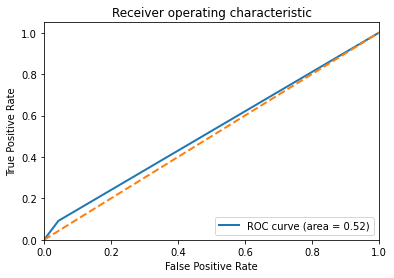

In [389]:
plt.plot(fpr, tpr, lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()